In [1]:
import random
import math
        
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt  

In [2]:
def do_generate_x_y(isTrain, batch_size, seqlen):
    batch_x = []
    batch_y = []
    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1

        sin_data = amp_rand * np.sin(np.linspace(
            seqlen / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seqlen / 15.0 * freq_rand * 3.0 * math.pi + offset_rand, seqlen * 2)  )

        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2

        sig_data = amp_rand * np.cos(np.linspace(
            seqlen / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seqlen / 15.0 * freq_rand * 3.0 * math.pi + offset_rand, seqlen * 2)) + sin_data

        batch_x.append(np.array([ sig_data[:seqlen] ]).T)
        batch_y.append(np.array([ sig_data[seqlen:] ]).T)

    # shape: (batch_size, seq_length, output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # shape: (seq_length, batch_size, output_dim)

    return batch_x, batch_y

In [3]:
#生成15个连续序列，将con和sin随机偏移变化后的值叠加起来
def generate_data(isTrain, batch_size):
    seq_length =15
    if isTrain :
        return do_generate_x_y(isTrain, batch_size, seq_length)
    else:
        return do_generate_x_y(isTrain, batch_size, seq_length*2)
    
        
sample_now, sample_f = generate_data(isTrain=True, batch_size=3)
print("training examples : ")
print(sample_now.shape)
print("(seq_length, batch_size, output_dim)")

training examples : 
(15, 3, 1)
(seq_length, batch_size, output_dim)


In [4]:
seq_length = sample_now.shape[0]
batch_size = 10

output_dim = input_dim = sample_now.shape[-1]
hidden_dim = 12  
layers_num = 2

# Optmizer:
learning_rate =0.04
nb_iters = 100

lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting
        
        
tf.reset_default_graph()

In [5]:
encoder_input = []
expected_output = []
decode_input =[]
for i in range(seq_length):
    encoder_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )
    expected_output.append( tf.placeholder(tf.float32, shape=( None, output_dim)) )
    decode_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )

    
tcells = []
for i in range(layers_num):
    tcells.append(tf.contrib.rnn.GRUCell(hidden_dim))
Mcell = tf.contrib.rnn.MultiRNNCell(tcells)

dec_outputs, dec_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(encoder_input,decode_input,Mcell)

reshaped_outputs = []
for ii in dec_outputs :
    reshaped_outputs.append( tf.contrib.layers.fully_connected(ii,output_dim,activation_fn=None))


# L2 loss
output_loss = 0
for _y, _Y in zip(reshaped_outputs, expected_output):
    output_loss += tf.reduce_mean( tf.pow(_y - _Y, 2) )
   
# generalization capacity)
reg_loss = 0
for tf_var in tf.trainable_variables():
    if not ("fully_connected" in tf_var.name ):
        #print(tf_var.name)
        reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

loss = output_loss + lambda_l2_reg * reg_loss
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss) 

W1204 00:18:09.337869 140704968726272 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1204 00:18:09.338634 140704968726272 deprecation.py:323] From <ipython-input-5-77172579ef89>:12: GRUCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
W1204 00:18:09.339898 140704968726272 deprecation.py:323] From <ipython-input-5-77172579ef89>:13: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for up

W1204 00:18:09.686842 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:09.730247 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7b810f470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:09.907032 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7b810f470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7b810f470>>: AttributeError: module 'gast' has no attribute 'Num'
W1204 00:18:09.976908 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of 

W1204 00:18:10.151351 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:10.228174 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:10.394126 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:10.417690 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7b810f470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:10.651638 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:10.729594 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:10.895519 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:10.919716 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7b810f470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:11.154346 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:11.231550 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:11.397714 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:11.421533 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7b810f470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:11.653634 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:11.803295 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:11.894227 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f710>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:11.971096 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:12.137403 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7b810f7f0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:12.162998 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7e218cb70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:12.346148 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:12.370796 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7e218cb70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:12.604818 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:12.682539 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:12.849367 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:12.872948 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7e218cb70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:13.109489 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:13.185575 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:13.350105 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:13.373720 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7e218cb70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:13.609192 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:13.687212 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:13.853501 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:13.876326 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7e218cb70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:14.114210 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:14.191729 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:14.356121 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:14.379920 140704968726272 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff7e218cb70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call 

W1204 00:18:14.612200 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e218cf98>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:14.689981 140704968726272 ag_logging.py:145] Entity <bound method GRUCell.call of <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7ff7e2180160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method GRUCell.call of <tensorflow.

W1204 00:18:14.900069 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e6c86a0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e6c86a0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:14.994142 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e5d0b70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object 

W1204 00:18:15.188979 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e6c86a0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e6c86a0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:15.284007 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e0f9fd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object 

W1204 00:18:15.482312 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e0924e0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e0924e0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:15.653126 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79e6c86a0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object 

W1204 00:18:15.750227 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff7ee27d048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff7ee27d048>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:15.846582 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff7e2417e10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object 

W1204 00:18:16.039066 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff7b81b3780>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff7b81b3780>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1204 00:18:16.134675 140704968726272 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x7ff79dff7080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object 

W1204 00:18:16.385612 140704968726272 deprecation.py:323] From /home/lx/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
sess = tf.InteractiveSession()
        
def train_batch(batch_size):

    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})

    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t


def test_batch(batch_size):
    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)#来预测最后一个序列
    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})    
    output_lossv,reg_lossv,loss_t = sess.run([output_loss,reg_loss,loss], feed_dict)
    print("-----------------")    
    print(output_lossv,reg_lossv)
    return loss_t


# Training
train_losses = []
test_losses = []


-----------------
6.72486 109.57072
Step 0/100, train loss: 6.974181652069092, 	TEST loss: 7.053572177886963
-----------------
1.4119594 103.22191
Step 50/100, train loss: 1.0089714527130127, 	TEST loss: 1.7216250896453857
-----------------
0.7232927 89.15887
Step 100/100, train loss: 1.0196678638458252, 	TEST loss: 0.9907692670822144
Fin. train loss: 1.0196678638458252, 	TEST loss: 0.9907692670822144


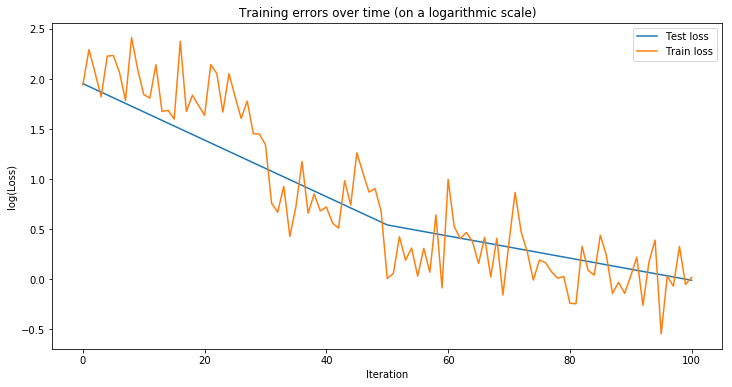

In [7]:
sess.run(tf.global_variables_initializer())
for t in range(nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    if t % 50 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t,nb_iters, train_loss, test_loss))
print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))        
        
        
        
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(0, len(test_losses))) /
    float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),label="Test loss")
    
plt.plot(np.log(train_losses),label="Train loss")
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()        

visualize 5 predictions data:
(30, 5, 1) (30, 5, 1)
(15, 5, 1)


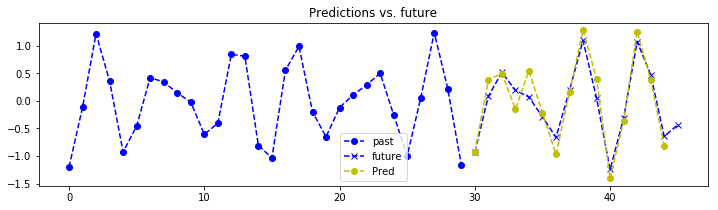

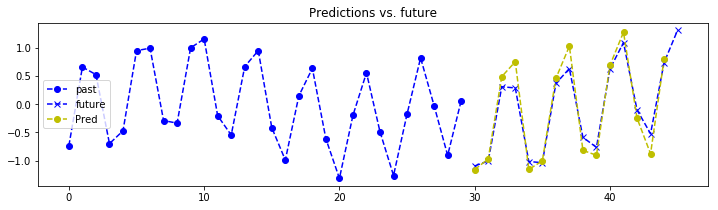

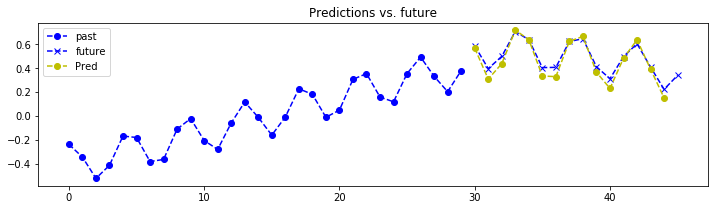

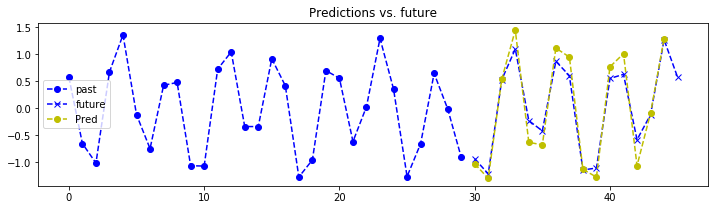

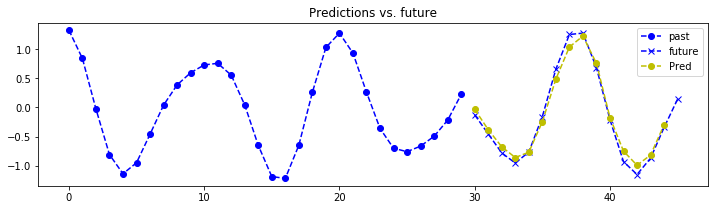

In [8]:
# Test
nb_predictions = 5
print("visualize {} predictions data:".format(nb_predictions))

preout =[]
X, Y = generate_data(isTrain=False, batch_size=nb_predictions)
print(np.shape(X),np.shape(Y))
for tt in  range(seq_length):
    feed_dict = {encoder_input[t]: X[t+tt] for t in range(seq_length)}
    feed_dict.update({expected_output[t]: Y[t+tt] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[tt:seq_length+tt-1]),axis = 0)  #从前15个的最后一个开始预测  

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})
    outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    preout.append(outputs[-1])

print(np.shape(preout))#将每个未知预测值收集起来准备显示出来。
preout =np.reshape(preout,[seq_length,nb_predictions,output_dim])

for j in range(nb_predictions):
    plt.figure(figsize=(12, 3))

    for k in range(output_dim):
        past = X[:, j, k]
        expected = Y[seq_length-1:, j, k]#对应预测值的打印

        pred = preout[:, j, k]

        label1 = "past" if k == 0 else "_nolegend_"
        label2 = "future" if k == 0 else "_nolegend_"
        label3 = "Pred" if k == 0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected) + len(past)),
                 expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred) + len(past)),
                 pred, "o--y", label=label3)

    plt.legend(loc='best')
    plt.title("Predictions vs. future")
    plt.show()
